# I&E Study 7.1 Automated Stakeholder Analysis for Hedera


In this Notebook we will demonstrate how to scrape, clean, analyse and visualise data from different resources to do stakeholder analysis for Hedera.

In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Scraping

First we will gather data from the website https://seepnetwork.org. More specifically we will collect the data of the members of the seepnetwork.

For this we will define a method that will download the data, or if we already have the file in our local folder we just load it from there to reduce network traffic towards there website.

In [2]:
import requests
import os
from pathlib import Path
from bs4.element import Comment

def load_page(name, path):
    
    displayname = name.replace('https://', '').replace('http://', '').replace('/', '')
    full_path = path+displayname
    
    content = ""
    
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            content = f.read().replace("\n", "").replace("\t", "")
    except (OSError, IOError) as e:
        url = name
        if "http" not in url:
            url = "http://" + url
        print("parsing: " + url)
        response = requests.get(url)
        directory = os.path.dirname(full_path)
        Path(directory).mkdir(parents=True, exist_ok=True)
        open(full_path, 'wb').write(response.content)
        content = response.content
        
    return content 

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

First we will scrape the main page.

In [3]:
file_dir = "webpages/"
parent_page = "https://seepnetwork.org"
main_content = load_page(parent_page + "/Profiles", file_dir)

Next we will get all of the links to the individual member profile pages. Therefor we select all of the elements and extract the href field.

In [4]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(main_content)

sub_links = []
for link in bs.select(".mapListViewItem .button.border.blue a"):
    sub_links.append(link["href"])
    
print(f'We found {len(sub_links)} members.')

We found 96 members.


To get the members data we download the profile pages and parse the needed fields into an array for further processing.

In [5]:
data = []

for link in sub_links:
    content = load_page(parent_page+link, file_dir)
    bs = BeautifulSoup(content)
    parts = bs.select(".sidebar.left")
    
    name = parts[0].select_one("h3").string.strip()
#   years_of_membership = parts[0].select_one(".sidebarRight > p").string[0]
    location = parts[0].select_one(".sidebarRight .twoColLeft > p").contents[-1].strip()
    website = parts[0].select_one(".sidebarRight .twoColRight a")['href'].strip()
    org_type = parts[0].select_one(".sidebarRight .twoColRight > p").contents[-1].strip()
    mission_statement = parts[1].select(".sidebarRight > p")[0].contents[-1].strip()
    countries_of_involvement = parts[1].select(".sidebarRight > p")[1].contents[-1].strip()
    practice_areas = parts[1].select(".sidebarRight > p")[2].contents[-1].strip()
    website_content = ""
    error_loading_website = False
    try:
        website_html = load_page(website, file_dir)
        if len(website_html) > 7232460:
            raise Exception("Website to large")
        texts = BeautifulSoup(website_html).findAll(text=True)
        visible_texts = filter(tag_visible, texts)  
        website_content = u" ".join(t.strip() for t in visible_texts)
    except Exception as err:
        error_loading_website = True
        print("unable to parse website content: " + website, err)
    data.append([name, location, website, org_type, mission_statement, countries_of_involvement, practice_areas, website_content, error_loading_website])

parsing: http://www.ama.org.af/
unable to parse website content: http://www.ama.org.af/ HTTPConnectionPool(host='127.0.0.1', port=7890): Max retries exceeded with url: http://ama.org.af/ (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))
parsing: http://www.amfa.az/
unable to parse website content: http://www.amfa.az/ HTTPConnectionPool(host='127.0.0.1', port=7890): Max retries exceeded with url: http://www.amfa.az/ (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))
parsing: http://www.amfi-kenya.com
unable to parse website content: www.amfi-kenya.com HTTPConnectionPool(host='127.0.0.1', port=7890): Max retries exceeded with url: http://www.amfi-kenya.com/ (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))
parsing: http://www.apsfd-ci.net/
unable to parse website content: http://www

In [6]:
# One Example
data[3]

['AMA - Afghanistan Microfinance Association',
 'Afghanistan',
 'http://www.ama.org.af/',
 'National, Regional, Global Network',
 'To build an inclusive, sustainable and responsible development finance sector through policy advocacy, knowledge management, coordination & networking, and capacity building.',
 'Afghanistan',
 'Financial Inclusion',
 '',
 True]

Finally we write the parsed information into a csv file which can later be used as an input for the machine learning algorithms.

In [7]:
import csv
wtr = csv.writer(open ('member_data.csv', 'w', encoding='utf-8'), delimiter=',', lineterminator='\n')
for member in data :
    wtr.writerow (member)
    
wtr = csv.writer(open ('member_data_without_website.csv', 'w', encoding='utf-8'), delimiter=',', lineterminator='\n')
for member in data :
    wtr.writerow (member[:-2])


## Analyzing the data


### Load Data in Pandas DataFrame 

First of all we load all data into a pandas data frame. 

In [8]:
import pandas as pd

df = pd.read_csv(
    "member_data.csv",
    header=None,
    names=[
        "name",
        "location",
        "website",
        "org_type",
        "mission_statement",
        "countries_of_involvement",
        "practice_areas",
        "website_content",
        "error_loading_website"
    ],
)

In [9]:
import nltk
import numpy as np

nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# all_stopwords = stopwords.words("english")
# all_stopwords.extend(
#     [
#         "Twitter",
#         "Linkedin-in",
#         "work",
#         "Youtube",
#         "Facebook-f",
#         "About",
#         "s",
#         "site"
#     ]
# )
import math
from langdetect import detect
from nltk import sent_tokenize
from google_trans_new import google_translator

translator = google_translator()


def translate(text):
    lang = detect(text)
    if lang != "en":
        sent_token = sent_tokenize(text)
        translatedText = [
            translator.translate(sent, lang_tgt="en") for sent in sent_token
        ]
        text = (" ").join(translatedText)
        return text
    return text


# def delete_stop_words(text, error=False):
#     if not error:
#         text = translate(text)

#         text_tokens = word_tokenize(text)

#         tokens_without_sw = [
#             word.strip().lower()
#             for word in text_tokens
#             if not word.strip().lower() in all_stopwords
#         ]
#         return (" ").join(tokens_without_sw)
#     else:
#         # clean website_content
#         return ""

def translate_text(text, error=False):
    if not error:
        return translate(text)        
    else:
        # clean website_content
        return ""

filter_content = [
    "403 forbidden nginx",
    "http://courtesy.amen.pt/index.html?pType=expired ",
    "The website is under construction",
]

df["error_loading_website"] = np.where(
    df["website_content"].str.contains(r"403|forbidden|expired|under construction|down for maintainance", na=True), True, df["error_loading_website"]
)

df["website_content"] = df.apply(
    lambda member: translate_text(
        member.website_content, member.error_loading_website
    ),
    axis=1,
)
df["mission_statement"] = df.apply(
    lambda member: translate_text(
        member.mission_statement
    ),
    axis=1,
)

df.to_csv("clean_translate_data.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


For each organisation with have name, location, website link, organization type, their mission statement, countries of involvement, practice areas.

In [10]:
pd.set_option('display.max_colwidth',200)
df.head(20)

,name,location,website,org_type,mission_statement,countries_of_involvement,practice_areas,website_content,error_loading_website
0,Access to Finance Rwanda,Rwanda,http://www.afr.rw/,Development Organization,"Low income Rwandans, especially women and youth, benefit from use of a variety of appropriate financial services",Rwanda,"Fragile & Conflict-affected Environments, Gender Equality, Health, Housing",Search Twitter Linkedin-in Youtube Facebook-f Who we are About us Our History How we work Our Team Partners Focus Areas Supporting Underserved and Marginalised Groups Agriculture Financing Digitiz...,False
1,AEMFI - Association of Ethiopian Microfinance Institutions,Ethiopia,http://www.aemfi-ethiopia.org/,"National, Regional, Global Network","To enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance, human capital development...",Ethiopia,Education; Environment & Climate; Financial Consumer Protection; Financial Inclusion; Housing; Livelihoods; MSME Development; Rural & Agricultural Development; Savings-Led Community Finance; Urban...,,True
2,Aga Khan Foundation USA,United States,https://www.akfusa.org/,Development Organization,"Promote social development, primarily in low income countries.",Afghanistan; Bangladesh; India; Kenya; Kyrgyzstan; Madagascar; Mali; Mozambique; Pakistan; Tajikistan; Tanzania,"Education; Financial Consumer Protection; Food Security & Nutrition; Gender Equality; Rural & Agricultural Development; Urban Development; WASH (Water, Sanitation, & Hygiene); Youth & Children",,True
3,AMA - Afghanistan Microfinance Association,Afghanistan,http://www.ama.org.af/,"National, Regional, Global Network","To build an inclusive, sustainable and responsible development finance sector through policy advocacy, knowledge management, coordination & networking, and capacity building.",Afghanistan,Financial Inclusion,,True
4,AMFA - Azerbaijan Micro-Finance Association,Azerbaijan,http://www.amfa.az/,"National, Regional, Global Network",To strengthen the capacity of micro-finance institutions and to promote effective collective action in advancing the interests of the micro-finance community and its clients.,Azerbaijan,Financial Consumer Protection; Financial Inclusion; Gender Equality; MSME Development,,True
5,AMFI Kenya,Kenya,www.amfi-kenya.com,"National, Regional, Global Network","To champion the aspirations of microfinance institutions through advocacy, capacity building, linkages and research.",Kenya,"Financial Consumer Protection, Financial Inclusion, Housing, Livelihoods, Market Systems Development, MSME Development, Rural & Agricultural Development, Savings-Led Community Finance, WASH (Water...",,True
6,AMFIU - Association of Microfinance Institutions of Uganda,Uganda,http://www.amfiu.org.ug,"National, Regional, Global Network","To promote a professional, inclusive and responsive microfinance industry that contributes to transformation of livelihoods of Ugandans.",Uganda,Financial Consumer Protection; Financial Inclusion; Rural and Agricultural Development,"Plot 679 Wamala Road, AMFIU House, Najjanankumbi 0414-259176, 0414 677176 amfiu@amfiu.org.ug AMFIU Sidebar × Home About AMFIU What We Do Membership News & Events Resources AMFIU...",False
7,AMIR - Association of Micro Finance Institutions in Rwanda,Rwanda,http://www.amir.org.rw,"National, Regional, Global Network",The mission of AMIR is to offer diversified services to microfinance institutions to enable them to work professionally and contribute to poverty reduction in a sustainable manner.,Rwanda,"Education, Financial Consumer Protection, Financial Inclusion, Savings-Led Community Finance",,True
8,APIM Madagascar - Association Professionnelle des Institutions de Microfinance,Madagascar,http://www.apimfmada.mg/,"National, Regional, Global Network",Promote financial inclusion or access to financial services; encourage cooperation between microfinance instituti

In [11]:
from pandas_profiling import ProfileReport

df_selected = df.loc[:, ["name", "org_type", "countries_of_involvement", "location", ]]
profile = ProfileReport(
    df,
    title="Pandas Profiling Report",
    correlations=None,
    samples=None,
    missing_diagrams=None,
    duplicates=None,
)
profile.to_notebook_iframe()

### Most Common Practice Areas

Each of the members is assigned to several practice areas. We take a look at which practice areas are most common among the members.

In [12]:
# Practice area dict
practice_areas = {}

# Add practice areas to dictionary
def count_areas(areas):
    for area in areas:
        if area in practice_areas:
            practice_areas[area] += 1
        else:
            practice_areas[area] = 1  

In [13]:
import numpy as np
import operator
# Load the regular expression library
import re

# Convert practice areas string to list of areas
df["practice_areas"] = df["practice_areas"].replace(np.nan, '', regex=True)
df["practice_areas"] =  df.apply(lambda x: re.sub(r'\([^)]*\)', '',x["practice_areas"]), axis=1)
df["practice_areas"] = df.apply(lambda x: [area.strip() for area in re.split('; |,',x["practice_areas"])], axis=1)
df.apply(lambda x: count_areas(x["practice_areas"]), axis=1)

# Print 10 most commom practice areas
most_common_pratice_areas = dict(sorted(practice_areas.items(), key=operator.itemgetter(1), reverse=True)[:10])

In [14]:
most_common_pratice_areas

{'Financial Inclusion': 83,
 'Gender Equality': 62,
 'Livelihoods': 57,
 'Market Systems Development': 52,
 'Savings-Led Community Finance': 50,
 'Youth & Children': 50,
 'MSME Development': 48,
 'Rural & Agricultural Development': 44,
 'Education': 43,
 'Food Security & Nutrition': 33}

<BarContainer object of 10 artists>

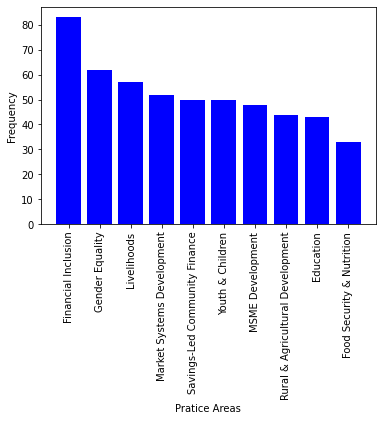

In [15]:
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Pratice Areas')
plt.bar(most_common_pratice_areas.keys(), most_common_pratice_areas.values(), color='b')

### Mission Statement Modeling

We use regular expression for cleaning the mission statement. We delete all non word characters and replace all uppercase letters with lowercase letters. 

In [16]:
# Remove punctuation
df["mission_statement_processed"] = df["mission_statement"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
df["website_content_processed"] = df["website_content"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
# Convert the tex to lowercase
df["mission_statement_processed"] = df["mission_statement_processed"].map(lambda x: x.lower())
df["website_content_processed"] = df["website_content_processed"].map(lambda x: x.lower())
df["processed_text"] = df["mission_statement_processed"] + df["website_content_processed"]

df.to_csv("processed_data.csv")
# Print out the first rows
df[["mission_statement", "mission_statement_processed", "website_content", "website_content_processed", "processed_text"]][5:10]

,mission_statement,mission_statement_processed,website_content,website_content_processed,processed_text
5,"To champion the aspirations of microfinance institutions through advocacy, capacity building, linkages and research.",to champion the aspirations of microfinance institutions through advocacy capacity building linkages and research,,,to champion the aspirations of microfinance institutions through advocacy capacity building linkages and research
6,"To promote a professional, inclusive and responsive microfinance industry that contributes to transformation of livelihoods of Ugandans.",to promote a professional inclusive and responsive microfinance industry that contributes to transformation of livelihoods of ugandans,"Plot 679 Wamala Road, AMFIU House, Najjanankumbi 0414-259176, 0414 677176 amfiu@amfiu.org.ug AMFIU Sidebar × Home About AMFIU What We Do Membership News & Events Resources AMFIU...",plot 679 wamala road amfiu house najjanankumbi 0414-259176 0414 677176 amfiu@amfiuorgug amfiu sidebar × home about amfiu what we do membership news & events resources amfiu work...,to promote a professional inclusive and responsive microfinance industry that contributes to transformation of livelihoods of ugandans plot 679 wamala road amfiu house najjanankumbi 0414-259176...
7,The mission of AMIR is to offer diversified services to microfinance institutions to enable them to work professionally and contribute to poverty reduction in a sustainable manner.,the mission of amir is to offer diversified services to microfinance institutions to enable them to work professionally and contribute to poverty reduction in a sustainable manner,,,the mission of amir is to offer diversified services to microfinance institutions to enable them to work professionally and contribute to poverty reduction in a sustainable manner
8,Promote financial inclusion or access to financial services; encourage cooperation between microfinance institutions; ensure the representation and defense of the collective interests of microfina...,promote financial inclusion or access to financial services; encourage cooperation between microfinance institutions; ensure the representation and defense of the collective interests of microfina...,"Professional Association of Microfinance Institutions Fifanomezantanana mirindra, fampandrosoana ho an'ny rehetra Go to content Home APIMF MISSIONS Structure The General Assembly The Board of Dire...",professional association of microfinance institutions fifanomezantanana mirindra fampandrosoana ho an'ny rehetra go to content home apimf missions structure the general assembly the board of direc...,promote financial inclusion or access to financial services; encourage cooperation between microfinance institutions; ensure the representation and defense of the collective interests of microfina...
9,The Professional Association of Decentralized Financial Systems of Burkina Faso (APSFD-BF)'s mission is to defend the material and moral interests of the profession and to reinforce the capacities...,the professional association of decentralized financial systems of burkina faso (apsfd-bf)'s mission is to defend the material and moral interests of the profession and to reinforce the capacities...,Home Presentation History Mission and vision Our objectives Executive Management Bodies General Assembly Board of Directors Statutory Auditors Ethics and Deontology Committee News Members Membersh...,home presentation history mission and vision our objectives executive management bodies general assembly board of directors statutory auditors ethics and deontology committee news members membersh...,the professional association of decentralized financial systems of burkina faso (apsfd-bf)'s mission is to defend the material and moral interests of the profession and to reinforce the capacities...


#### Word Cloud

To determine the most common words in the mission statements, we created a Wordcloud. 

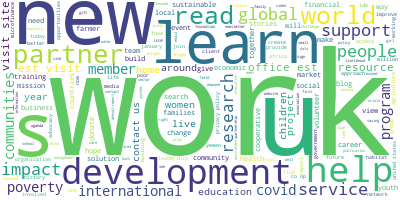

In [17]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['processed_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### 10 Most Common Features

We also used the CountVectorizer from sklearn to plot the 10 most common words in the mission statements.

In [18]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [19]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    # print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

D:\soft\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['facebook', 'linkedin', 'twitter', 'youtube'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


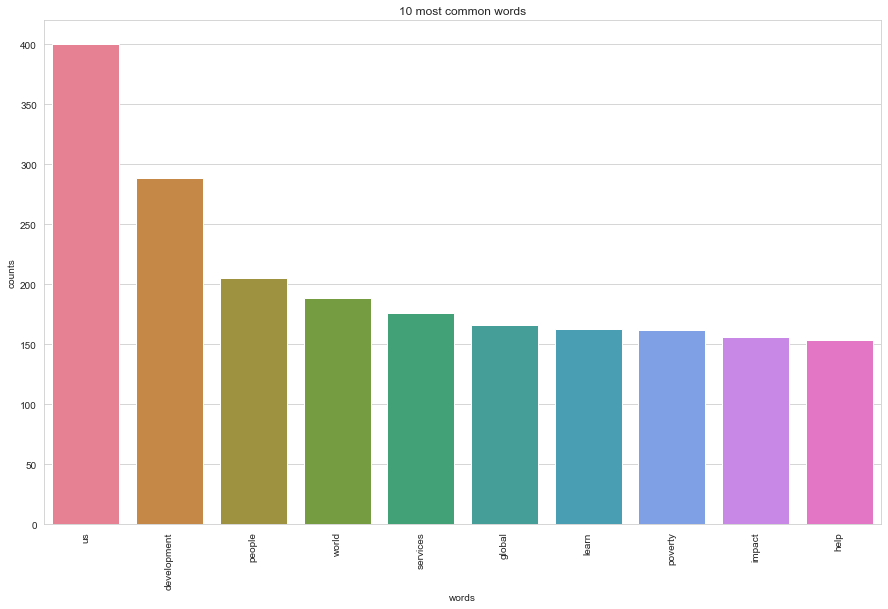

In [20]:
# Initialise the count vectorizer with the English stop words
all_stopwords = stopwords.words("english")
all_stopwords.extend(
    [
        "Twitter",
        "Linkedin-in",
        "work",
        "Youtube",
        "Facebook-f",
        "About",
        "s",
        "site",
        "news"
    ]
)
count_vectorizer = CountVectorizer(stop_words=all_stopwords)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['processed_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### LDA

In order to get an even better understanding of the members mission, we use the Latent Dirichlet allocation algorithm. This method groups words into topics and rank the words according to their probability.

We set the number of topics to 5 and want to get the 10 most common words in those topics. 

In [21]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [22]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1:d}:")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [27]:
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, max_iter=50, random_state=100, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics found via LDA:

Topic #1:
people business us enterprise village partners learn development poverty program

Topic #2:
development services us microfinance economic financial global new international research

Topic #3:
us world poverty help learn donate 2020 people give change

Topic #4:
us microfinance development people global 19 covid contact children world

Topic #5:
office visit est us development world impact hope read habitat


#### PyLDAvis

We also tried a Python library for interactive topic model visualization called pyLDAvis.

In [28]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
%%time
# LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 2.99 s


In [30]:
pyLDAvis.enable_notebook()
pyLDAvis.display(LDAvis_prepared)

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
